# Signal alignment comparison between f5c and Remora

This notebooks aims to visualise the global differences in signal alignments made by f5c and Remora.
Content of this notebook:
1. Import of required python packages
2. Functions
3. Data loading
4. Signal coverage
5. Dwell analysis

## 1. Import of required python packages

In [1]:
# ---- General packages ----
import logging
import pickle
import random
import numpy as np
import pandas as pd
import pingouin as pg
from datetime import datetime
from pathlib import Path
import polars as pl
import patchworklib as pw
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# ---- Specific packages for input ----
import pod5
from pod5 import DatasetReader
import pysam
from remora import io, refine_signal_map, util

# Silence Remora DEBUG messages
logging.getLogger("Remora").setLevel(logging.INFO)

<Figure size 100x100 with 0 Axes>

## 2. Functions

In [2]:
def convert_kmers_to_base_positions(
    df, 
    center_index =5):

    """
    Goal: this function assigns the mean signal level per k-mer to the center position within k-mer.
    Parameters:
        df: pd.DataFrame, made from .tsv output of f5c
        center_index: int, the index of the center base position within k-mer
    """
    # Add column with the center base position
    df = df.rename(columns={'position': 'kmer_position'})
    kmer_positions = df['kmer_position']
    kmer_positions_list = list(kmer_positions)
    base_positions_list = [kmer_position + center_index for kmer_position in kmer_positions]
    df.insert(2, "base_position", base_positions_list)

    # Add column with the center base
    reference_kmers = df['reference_kmer']
    reference_kmers_list = list(reference_kmers)
    reference_base_list = [reference_kmer[center_index] for reference_kmer in reference_kmers_list]
    df.insert(4, "reference_base", reference_base_list)

    return df

In [3]:
def remora_coverage_df(
    list_of_samples_metrics,
    positions_range=[0, 100]):
    """
    Goal: create a DataFrame with coverage per position across multiple samples for Remora output.

    Parameters:
        list_of_samples_metrics: list of metric dicts for each sample
        positions_range: range of positions to visualize on x-axis
    Returns:
        coverage_results: DataFrame with coverage per position per sample
    """
    filtered_samples = [sample for sample in list_of_samples_metrics if sample is not None]

    # Convert all samples to DataFrames
    sample_dfs = [pd.DataFrame(sample[0]['trimmean']) for sample in filtered_samples]

    positions_ref_reg = list(range(positions_range[0], positions_range[1]))
    results = []

    for pos in positions_ref_reg:
        row = {'position': pos}
        for idx, df in enumerate(sample_dfs):
            col_data = df[pos].dropna() if pos in df.columns else pd.Series(dtype=float)
            row[f'num_sample_{idx+1}'] = len(col_data)
        results.append(row)

    coverage_results = pd.DataFrame(results)
    return coverage_results

In [4]:
def f5c_coverage_df(
    *f5c_outputs, 
    positions_range=[0, 100]
):
    """
    Goal: create a DataFrame with coverage per position across multiple samples for f5c output.
    """
    list_of_positions = list(range(positions_range[0], positions_range[1]+1))
    coverage_results = []
    for position in list_of_positions:
        result = {'position': position}
        for i, df in enumerate(f5c_outputs, start=1):
            coverage = df[df['base_position'] == position]['read_name'].nunique()
            result[f'Coverage_{i}'] = coverage
        coverage_results.append(result)
    # Convert to DataFrame
    coverage_df = pd.DataFrame(coverage_results)
    return coverage_df

### Plotting functions

In [5]:
def plot_coverage_lines(
    coverage_df, 
    sample_labels=None, 
    title=None,
    legend = 'yes',
    alpha_lines = 1,
    colors = ['#0072B2', '#E69F00', '#009E73'],
    yticks=(0, 20000, 1000)
):
    """
    Plot coverage line plot for an arbitrary number of samples over positions.

    Parameters:
        coverage_df: pandas DataFrame with columns ['position', 'num_sample_1', ..., 'num_sample_N']
        sample_labels: list[str], optional list of labels for the samples; must match number of sample columns
        title: str, title for the plot
        legend: str, whether to plot the legend or not
        alpha_lines: float, transparency of the lines
        colors: list[str], the colours to use
        yticks: tuple, indicating the start of y-axis, end of y-axis and the step size for the yticks
    """
    plt.figure(figsize=(8, 4))

    # Extract sample columns (exclude 'position')
    sample_columns = [col for col in coverage_df.columns if col != 'position']

    # Use default labels if none provided
    if sample_labels is None:
        sample_labels = sample_columns  # Use column names as labels
    elif len(sample_labels) != len(sample_columns):
        raise ValueError("Length of sample_labels must match the number of sample columns in coverage_df.")


    # Plot each sample line
    for i, col in enumerate(sample_columns):
        plt.plot(
            coverage_df['position'], 
            coverage_df[col], 
            label=sample_labels[i], 
            color=colors[i % len(colors)],
            alpha = alpha_lines,
            linewidth=1
        )
    # Plot a horizontal red line to indicate the threshold used in downstream analysis
    plt.axhline(y=30, color='red', linestyle='--', linewidth=1, label='Minimum signal coverage\nthreshold (n=30)')

    plt.xlabel('Position', fontsize = 11)
    plt.ylabel('Absolute number of reads', fontsize = 11)
    if title:
        plt.title(title)
    if legend == 'yes':
        plt.legend(loc='center left',  bbox_to_anchor=(1.0, 0.5), fontsize=11)
    plt.ylim(yticks[0], yticks[1])
    plt.xlim(0,90)
    plt.xticks(ticks=range(0, 91, 10),fontsize=11)  # x-axis tick labels
    plt.yticks(ticks= range(yticks[0], yticks[1], yticks[2]), fontsize=11) 
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [6]:
def plot_coverage_lines_Remora_vs_f5c(
    coverage_df_Remora, coverage_df_f5c, 
    sample_labels=None, 
    title=None, 
    ylim=(0, 20000),
    plot_legend= 'yes'):
    """
    Plot coverage line plot for three tRNAs for two both signal alignment outputs over positions.

    Parameters:
        df: DataFrame with columns ['Position', 'Sample1', 'Sample2']
        sample_labels: List of two labels for the samples
        title: Optional title for the plot
        ylim: the range of the y-axis
    """
    if sample_labels is None:
        sample_labels = ['tRNA_1_Remora', 'tRNA_2_Remora', 'tRNA_3_Remora', 'tRNA_1_f5c', 'tRNA_2_f5c', 'tRNA_3_f5c']
    colors = ['#0072B2', '#E69F00', '#009E73']
    if plot_legend is not 'yes':
        plt.figure(figsize= (5,4))
    else:
        plt.figure(figsize=(8,4))

    
    # Plotting the Remora signal coverages
    plt.plot(coverage_df_Remora['position'], 
             coverage_df_Remora.iloc[:, 1], label=sample_labels[0], color=colors[0], linewidth=1, linestyle='-')
    plt.plot(coverage_df_Remora['position'], 
             coverage_df_Remora.iloc[:, 2], label=sample_labels[1], color=colors[1], linewidth=1, linestyle='-')
    plt.plot(coverage_df_Remora['position'],
             coverage_df_Remora.iloc[:, 3], label=sample_labels[2], color=colors[2], linewidth=1, linestyle='-')
    # Plotting the f5c signal coverages
    plt.plot(coverage_df_f5c['position'],
             coverage_df_f5c.iloc[:, 1], label=sample_labels[3], color=colors[0], linewidth=1, linestyle=':')
    plt.plot(coverage_df_f5c['position'],
             coverage_df_f5c.iloc[:, 2], label=sample_labels[4], color=colors[1], linewidth=1, linestyle=':')
    plt.plot(coverage_df_f5c['position'], 
             coverage_df_f5c.iloc[:, 3], label=sample_labels[5], color=colors[2], linewidth=1, linestyle=':')
    plt.axhline(y=30, color='red', linestyle='--', linewidth=1, label='Minimum signal coverage\nthreshold (n=30)')

    plt.xlabel("Base position", fontsize = 12)
    plt.ylabel('Absolute number of reads', fontsize = 12)
    if title:
        plt.title(title)

    # Making nice legend
    # Custom legend: one entry per sample, paired by color and labeled by method
    custom_lines = [
    Line2D([0], [0], color=colors[0], linestyle='-', linewidth=1, label=sample_labels[0]),
    Line2D([0], [0], color=colors[0], linestyle=':', linewidth=1, label=sample_labels[3]),
    Line2D([0], [0], color=colors[1], linestyle='-', linewidth=1, label=sample_labels[1]),
    Line2D([0], [0], color=colors[1], linestyle=':', linewidth=1, label=sample_labels[4]),
    Line2D([0], [0], color=colors[2], linestyle='-', linewidth=1, label=sample_labels[2]),
    Line2D([0], [0], color=colors[2], linestyle=':', linewidth=1, label=sample_labels[5]),
    ]
    custom_lines.append(Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='Minimum signal coverage\nthreshold (n=30)'))

    if plot_legend == 'yes':
        plt.legend(handles=custom_lines, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=11, ncol=1)

    plt.ylim(ylim)
    plt.xlim(0, 90)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.xticks(ticks=range(0, 100, 10),fontsize=12)  # x-axis tick labels
    plt.yticks(fontsize=12) 
    plt.tight_layout()
    plt.show()

In [7]:
def plot_median_dwell_and_stats_f5c(
    df_dict, 
    custom_palette={
    "Leu-CAA-1": "#0072B2",  
    "Glu-CTC-1": "#E69F00",  
    "Gly-GCC-2": "#009E73"
    },
    title= None,
    legend = 'yes',
):
    """
    Goal: Prints median dwell stats for each tRNA dataset and plots them.

    Parameters
        df_dict: dict, dictionary with keys as tRNA names and values as DataFrames.
            Each DataFrame must have columns: ["base_position", "dwell", "tRNA"].
        custom_palette: dict, dictionary mapping tRNA names to hex color codes.
        title: str, title of plot
        legend: str, 'yes' to plot legend
    """

    # 1. Print stats
    for name, df in df_dict.items():
        print(f"--- Median Dwell Stats for {name} ---")
        print(f"Minimum: {df['dwell'].min():.2f}")
        print(f"Maximum: {df['dwell'].max():.2f}")
        print(f"Median:  {df['dwell'].median():.2f}")
        print(f"Mean:    {df['dwell'].mean():.2f}")
        print(f"Std:     {df['dwell'].std():.2f}")
        print()

    # 2. Combine data
    median_combined = pd.concat(df_dict.values(), ignore_index=True)

    # 3. Plot
    plt.figure(figsize=(10, 5))
    sns.scatterplot(
        data=median_combined,
        x="base_position",
        y="dwell",
        hue="tRNA",
        palette=custom_palette,
        marker="o"
    )

    plt.title(title)
    plt.xlabel("Base Position")
    plt.ylabel("Median Dwell Time")
    plt.yticks(np.arange(0, 240, 20))
    plt.ylim(0, 220)
    if legend == 'yes':
        plt.legend(loc='center left',  bbox_to_anchor=(1.0, 0.5), fontsize=11)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_median_dwell_and_stats_remora(
    df_dict, 
    custom_palette={
    "Leu-CAA-1": "#0072B2",  
    "Glu-CTC-1": "#E69F00",  
    "Gly-GCC-2": "#009E73"
    },
    title= None,
    legend = 'yes',
):
    """
    Goal: Prints median dwell stats for each tRNA dataset and plots them.

    Parameters
        df_dict: dict, dictionary with keys as tRNA names and values as DataFrames.
            Each DataFrame must have columns: ["base_position", "dwell", "tRNA"].
        custom_palette: dict, dictionary mapping tRNA names to hex color codes.
        title: str, title of plot
        legend: str, 'yes' to plot legend
    """

    # Print stats
    for name, df in df_dict.items():
        print(f"--- Dwell Stats for {name} ---")
        print(f"Minimum: {df.min().min():.2f}")
        print(f"Maximum: {df.max().max():.2f}")
        print(f"Median:  {df.stack().median():.2f}")
        print(f"Mean:    {df.stack().mean():.2f}")
        print(f"Std:    {df.stack().std():.2f}")
        print()

    # 2. Compute medians
    median_dfs = []
    for name, df in df_dict.items():
        median_series = df.median()
        median_df = pd.DataFrame({
            "position": median_series.index.astype(int),
            "tRNA": name,
            "dwell": median_series.values
        })
        median_dfs.append(median_df)
    # Melt the wide df_median into long format
    df_long = pd.concat(median_dfs, ignore_index=True)


    # Define custom colors
    custom_palette = { "Leu-CAA-1": "#0072B2","Glu-CTC-1": "#E69F00", "Gly-GCC-2": "#009E73"}


    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=df_long, x="position", y="dwell", hue="tRNA", palette=custom_palette,marker="o")

    plt.title(title)
    plt.xlabel("Base Position")
    plt.ylabel("Median Dwell Time")
    plt.ylim(0, 200)
    plt.yticks(np.arange(0, 200,20))
    if legend == 'yes':
        plt.legend(loc='center left',  bbox_to_anchor=(1.0, 0.5), fontsize=11)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 3. Data loading and preparation

### For Remora
See Remora_ionic_current_analysis_tRNAs.ipynb notebook for more details.

In [9]:
start_time = datetime.now()
print(f"Started at: {start_time}")

# Load the pod5 and bam files for both samples
own_data_root = Path("/data/fg24045")

print("IVT_Leu_CAA_1_1_WI")
pod5_dr_IVT_Leu = pod5.DatasetReader(own_data_root /"IVT_analysis"/ "complete"/"all_IVTs_merged.pod5") 
bam_fh_IVT_Leu = io.ReadIndexedBam(own_data_root/"IVT_analysis"/ "Leu_CAA_1_1_WI"/ "IVT_Leu_CAA_1_1_WI_primary_tagged_f5c_selected.bam")

print("IVT_Glu_CTC_1_1")
pod5_dr_IVT_Glu = pod5.DatasetReader(own_data_root /"IVT_analysis"/ "complete"/"all_IVTs_merged.pod5")  
bam_fh_IVT_Glu = io.ReadIndexedBam(own_data_root/"IVT_analysis"/ "Glu_CTC_1_1"/ "IVT_Glu_CTC_1_1_primary_tagged_f5c_selected.bam")

print("IVT_Gly_GCC_2_1")
pod5_dr_IVT_Gly = pod5.DatasetReader(own_data_root /"IVT_analysis"/ "complete"/"all_IVTs_merged.pod5") 
bam_fh_IVT_Gly = io.ReadIndexedBam(own_data_root/"IVT_analysis"/ "Gly_GCC_2_1"/ "IVT_Gly_GCC_2_1_primary_tagged_f5c_selected.bam")

print("Biological sample")
pod5_dr_bio = pod5.DatasetReader(own_data_root/'tRNA_RNA004_analysis'/'final_data'/'Ctrl_06_complete')
bam_fh_bio = io.ReadIndexedBam(own_data_root/"tRNA_RNA004_analysis"/'final_data'/"Ctrl_06_complete"/
                              "Ctrl_06_complete_f5c_selected.bam")


# Load the kmer-model table and set the signal mapping refiner
level_table = own_data_root / "IVT_analysis"/"Leu_CAA_1_1"/"9mer_levels_v1.txt"
sig_map_refiner = refine_signal_map.SigMapRefiner(
    kmer_model_filename=level_table,
    do_rough_rescale=True,
    scale_iters=1,
    do_fix_guage=True,
    sd_params=(50, 15, 1.5),
    half_bandwidth = 10
)
print(f"\nSignal Map Refiner:")
print(sig_map_refiner)
print(f"The parameters of the dwell_penalty algorithm are set to: {sig_map_refiner.sd_params}")

# Assigning the 6th base within each k-mer as dominant in order to convert signals-per-kmer to signals-per-base
sig_map_refiner.center_idx = 5
print(f"The index of the central base within k-mer is set to: {sig_map_refiner.center_idx}")
print("\n")

# Conduct signal alignment and calculate the trimmed mean signal levels for both samples
## For biological sample, three tRNAs
print(f"Signal alignment for biological sample:")
ref_reg_Leu = io.RefRegion(ctg="Homo_sapiens_tRNA-Leu-CAA-1-1-WI", strand="+", start=0, end=100)
start_time = datetime.now()
samples_metrics_bio_Leu, all_bam_reads = io.get_ref_reg_samples_metrics(
    ref_reg_Leu,
    [(pod5_dr_bio, bam_fh_bio)],
    metric="dwell_trimmean_trimsd",
    sig_map_refiner=sig_map_refiner, signal_type = 'norm')
print(f"\tLeu-CAA-1\tMetrics computed: {', '.join(samples_metrics_bio_Leu[0].keys())}")
print(f"\tLeu-CAA-1\tShape of metric array: {samples_metrics_bio_Leu[0]['trimmean'].shape}")

ref_reg_Glu = io.RefRegion(ctg="Homo_sapiens_tRNA-Glu-CTC-1-1", strand="+", start=0, end=100)
start_time = datetime.now()
samples_metrics_bio_Glu, all_bam_reads = io.get_ref_reg_samples_metrics(
    ref_reg_Glu,
    [(pod5_dr_bio, bam_fh_bio)],
    metric="dwell_trimmean_trimsd",
    sig_map_refiner=sig_map_refiner, signal_type = 'norm')
print(f"\tGlu-CTC-1\tMetrics computed: {', '.join(samples_metrics_bio_Glu[0].keys())}")
print(f"\tGlu-CTC-1\tShape of metric array: {samples_metrics_bio_Glu[0]['trimmean'].shape}")

ref_reg_Gly = io.RefRegion(ctg="Homo_sapiens_tRNA-Gly-GCC-2-1", strand="+", start=0, end=100)
start_time = datetime.now()
samples_metrics_bio_Gly, all_bam_reads = io.get_ref_reg_samples_metrics(
    ref_reg_Gly,
    [(pod5_dr_bio, bam_fh_bio)],
    metric="dwell_trimmean_trimsd",
    sig_map_refiner=sig_map_refiner, signal_type = 'norm')
print(f"\tGly-GCC-2\tMetrics computed: {', '.join(samples_metrics_bio_Gly[0].keys())}")
print(f"\tGly-GCC-2\tShape of metric array: {samples_metrics_bio_Gly[0]['trimmean'].shape}")

## For IVT sample, three tRNAs
print(f"Signal alignment for IVT sample:")
samples_metrics_IVT_Leu, all_bam_reads = io.get_ref_reg_samples_metrics(
    ref_reg_Leu,
    [(pod5_dr_IVT_Leu, bam_fh_IVT_Leu)],
    metric="dwell_trimmean_trimsd",
    sig_map_refiner=sig_map_refiner, signal_type = 'norm'
)
print(f"\tLeu-CAA-1\tMetrics computed: {', '.join(samples_metrics_IVT_Leu[0].keys())}")
print(f"\tLeu-CAA-1\tShape of metric array: {samples_metrics_IVT_Leu[0]['trimmean'].shape}")
samples_metrics_IVT_Glu, all_bam_reads = io.get_ref_reg_samples_metrics(
    ref_reg_Glu,
    [(pod5_dr_IVT_Glu, bam_fh_IVT_Glu)],
    metric="dwell_trimmean_trimsd",
    sig_map_refiner=sig_map_refiner, signal_type = 'norm'
)
print(f"\tGlu-CTC-1\tMetrics computed: {', '.join(samples_metrics_IVT_Glu[0].keys())}")
print(f"\tGlu-CTC-1\tShape of metric array: {samples_metrics_IVT_Glu[0]['trimmean'].shape}")
samples_metrics_IVT_Gly, all_bam_reads = io.get_ref_reg_samples_metrics(
    ref_reg_Gly,
    [(pod5_dr_IVT_Gly, bam_fh_IVT_Gly)],
    metric="dwell_trimmean_trimsd",
    sig_map_refiner=sig_map_refiner, signal_type = 'norm'
)
print(f"\tGly-GCC-2\tMetrics computed: {', '.join(samples_metrics_IVT_Gly[0].keys())}")
print(f"\tGly-GCC-2\tShape of metric array: {samples_metrics_IVT_Gly[0]['trimmean'].shape}")


end_time = datetime.now()
print(f"Finished at: {end_time}")
print(f"Total time taken: {end_time - start_time}")

Started at: 2025-08-12 09:22:19.845301
IVT_Leu_CAA_1_1_WI


Indexing BAM by parent read id: 6408 Reads [00:00, 63196.96 Reads/s]


IVT_Glu_CTC_1_1


Indexing BAM by parent read id: 18707 Reads [00:00, 50368.02 Reads/s]


IVT_Gly_GCC_2_1


Indexing BAM by parent read id: 15111 Reads [00:00, 69438.73 Reads/s]


Biological sample


Indexing BAM by parent read id: 14019 Reads [00:00, 70389.76 Reads/s]



Signal Map Refiner:
Loaded 9-mer table with 4 central position. Rough re-scaling will be executed. 1 rounds of signal mapping refinement followed by precise re-scaling will be executed. Signal mapping refinement will be executed using the dwell_penalty refinement method (band half width: 10). Short dwell penalty array set to [3750.  3601.5 3456.  3313.5 3174.  3037.5 2904.  2773.5 2646.  2521.5
 2400.  2281.5 2166.  2053.5 1944. ].
The parameters of the dwell_penalty algorithm are set to: (50, 15, 1.5)
The index of the central base within k-mer is set to: 5


Signal alignment for biological sample:
	Leu-CAA-1	Metrics computed: dwell, trimmean, trimsd
	Leu-CAA-1	Shape of metric array: (49, 100)
	Glu-CTC-1	Metrics computed: dwell, trimmean, trimsd
	Glu-CTC-1	Shape of metric array: (361, 100)
	Gly-GCC-2	Metrics computed: dwell, trimmean, trimsd
	Gly-GCC-2	Shape of metric array: (199, 100)
Signal alignment for IVT sample:
	Leu-CAA-1	Metrics computed: dwell, trimmean, trimsd
	Leu-CAA-1	Sha

### For F5c

See F5c_ionic_current_analysis_tRNAs.ipynb notebook for more details.

In [10]:
# Load in the .tsv output of f5c eventalign
# And convert the mean signal levels per k-mer to mean signal levels per reference position
print(f"Biological sample:")
f5c_output_bio_all = pd.read_csv('/data/fg24045/tRNA_RNA004_analysis/final_data/Ctrl_06_complete/f5c_eventalign/Ctrl_06_complete_f5c_eventaling_28juli_dwell.tsv',
                                 sep='\t')
print(f"\tAll\t\tNumber of reads: {f5c_output_bio_all['read_name'].nunique()}")

ref_reg_Leu= "Homo_sapiens_tRNA-Leu-CAA-1-1-WI"
f5c_output_bio_Leu = f5c_output_bio_all[f5c_output_bio_all['contig']==ref_reg_Leu]
f5c_output_bio_Leu = convert_kmers_to_base_positions(f5c_output_bio_Leu, center_index =5)
print(f"\tLeu-CAA-1\tNumber of reads: {f5c_output_bio_Leu['read_name'].nunique()}")
print(f"\tLeu-CAA-1\tThe dataframe has {f5c_output_bio_Leu.shape[0]} rows and {f5c_output_bio_Leu.shape[1]} columns")

ref_reg_Glu= "Homo_sapiens_tRNA-Glu-CTC-1-1"
f5c_output_bio_Glu = f5c_output_bio_all[f5c_output_bio_all['contig']==ref_reg_Glu]
f5c_output_bio_Glu = convert_kmers_to_base_positions(f5c_output_bio_Glu, center_index =5)
print(f"\tGlu-CTC-1\tNumber of reads: {f5c_output_bio_Glu['read_name'].nunique()}")
print(f"\tGlu-CTC-1\tThe dataframe has {f5c_output_bio_Glu.shape[0]} rows and {f5c_output_bio_Glu.shape[1]} columns")

ref_reg_Gly= "Homo_sapiens_tRNA-Gly-GCC-2-1"
f5c_output_bio_Gly = f5c_output_bio_all[f5c_output_bio_all['contig']==ref_reg_Gly]
f5c_output_bio_Gly = convert_kmers_to_base_positions(f5c_output_bio_Gly, center_index =5)
print(f"\tGly-GCC-2\tNumber of reads: {f5c_output_bio_Gly['read_name'].nunique()}")
print(f"\tGly-GCC-2\tThe dataframe has {f5c_output_bio_Gly.shape[0]} rows and {f5c_output_bio_Gly.shape[1]} columns")
print('\n')

print(f"IVT sample:")
f5c_output_IVT_Leu =  pd.read_csv('/data/fg24045/IVT_analysis/Leu_CAA_1_1_WI/Leu_CAA_1_1_WI_f5c_eventalign_28juli_dwell.tsv', sep='\t')
print(f"\tLeu-CAA-1\tNumber of reads: {f5c_output_IVT_Leu['read_name'].nunique()}")
f5c_output_IVT_Leu = convert_kmers_to_base_positions(f5c_output_IVT_Leu, center_index =5)
print(f"\tLeu-CAA-1\tThe dataframe has {f5c_output_IVT_Leu.shape[0]} rows and {f5c_output_IVT_Leu.shape[1]} columns")

f5c_output_IVT_Glu =  pd.read_csv('/data/fg24045/IVT_analysis/Glu_CTC_1_1/Glu_CTC_1_1_f5c_eventalign_28juli_dwell.tsv', sep='\t')
print(f"\tGlu-CTC-1\tNumber of reads: {f5c_output_IVT_Glu['read_name'].nunique()}")
f5c_output_IVT_Glu = convert_kmers_to_base_positions(f5c_output_IVT_Glu, center_index =5)
print(f"\tGlu-CTC-1\tThe dataframe has {f5c_output_IVT_Glu.shape[0]} rows and {f5c_output_IVT_Glu.shape[1]} columns")

f5c_output_IVT_Gly =  pd.read_csv('/data/fg24045/IVT_analysis/Gly_GCC_2_1/Gly_GCC_2_1_f5c_eventalign_28juli_dwell.tsv', sep='\t')
print(f"\tGly-GCC-2\tNumber of reads: {f5c_output_IVT_Gly['read_name'].nunique()}")
f5c_output_IVT_Gly = convert_kmers_to_base_positions(f5c_output_IVT_Gly, center_index =5)
print(f"\tGly-GCC-2\tThe dataframe has {f5c_output_IVT_Gly.shape[0]} rows and {f5c_output_IVT_Gly.shape[1]} columns")


Biological sample:
	All		Number of reads: 14022
	Leu-CAA-1	Number of reads: 52
	Leu-CAA-1	The dataframe has 2362 rows and 17 columns
	Glu-CTC-1	Number of reads: 361
	Glu-CTC-1	The dataframe has 15632 rows and 17 columns
	Gly-GCC-2	Number of reads: 199
	Gly-GCC-2	The dataframe has 7692 rows and 17 columns


IVT sample:
	Leu-CAA-1	Number of reads: 6408
	Leu-CAA-1	The dataframe has 440755 rows and 17 columns
	Glu-CTC-1	Number of reads: 18707
	Glu-CTC-1	The dataframe has 1030875 rows and 17 columns
	Gly-GCC-2	Number of reads: 15111
	Gly-GCC-2	The dataframe has 816692 rows and 17 columns


## 4. Signal coverage
The signal coverage is the number of reads that have a mean signal value assigned per base position. The mean signal values are used in the downstream statistical comparison. This depends on the behaviour of the signal alignment method: if the method allows reference base positions to be skipped when no signals match properly to the base position, the signal coverage will fluctuate, but when positions are not allowed to be skipped, each position within a read's signal alignment will have a mean signal level. In the latter case, the signal coverage will match the sequence coverage more closely.
Below is shown how the signal coverage resulting from Remora's and f5c's signal alignment can be inferred for both biological and IVT sample for three tRNAs.

### For Remora

#### Biological sample

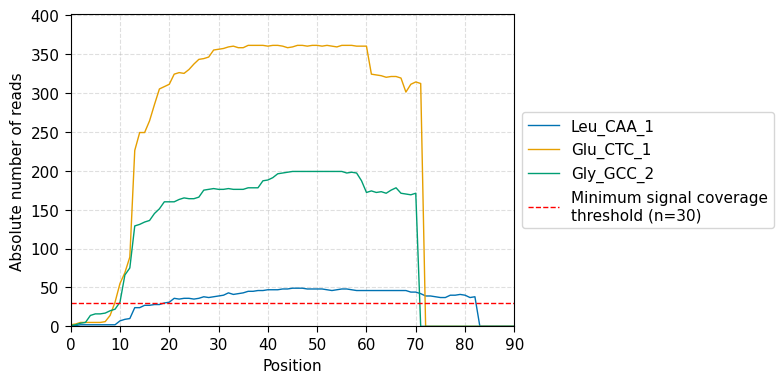

In [12]:
remora_bio_coverage_df = remora_coverage_df(
    [samples_metrics_bio_Leu, 
     samples_metrics_bio_Glu, 
     samples_metrics_bio_Gly],
    positions_range = [0, 100])
plot_coverage_lines(remora_bio_coverage_df, 
                            sample_labels= ['Leu_CAA_1', 'Glu_CTC_1', 'Gly_GCC_2']
                            , title=None, yticks=(0, 401, 50))

#### IVT sample

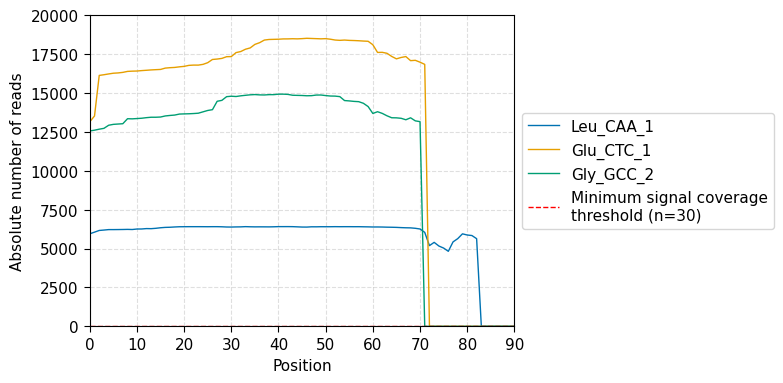

In [14]:
remora_IVT_coverage_df = remora_coverage_df(
    [samples_metrics_IVT_Leu, 
     samples_metrics_IVT_Glu,
     samples_metrics_IVT_Gly],
    positions_range = [0, 100])
plot_coverage_lines(remora_IVT_coverage_df, 
                            sample_labels= ['Leu_CAA_1', 'Glu_CTC_1', 'Gly_GCC_2']
                            , title=None, yticks=(0, 20001, 2500))

### For F5c

#### Biological sample

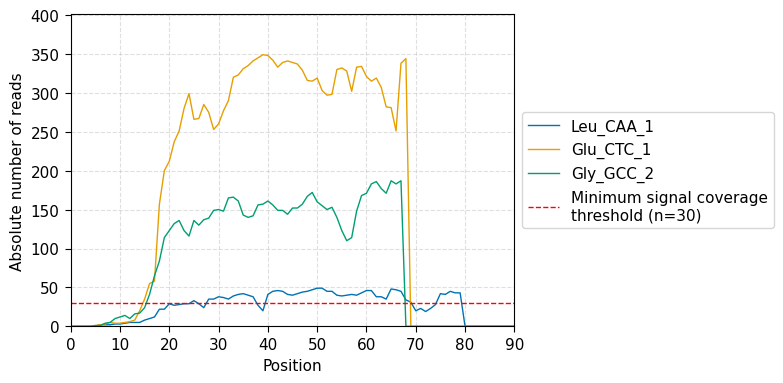

In [15]:
f5c_bio_coverage_df = f5c_coverage_df(
    f5c_output_bio_Leu, f5c_output_bio_Glu, f5c_output_bio_Gly, 
    positions_range=[0, 100])
plot_coverage_lines(f5c_bio_coverage_df, 
                            sample_labels= ['Leu_CAA_1', 'Glu_CTC_1', 'Gly_GCC_2']
                            , title=None, yticks=(0, 401, 50))

#### IVT sample

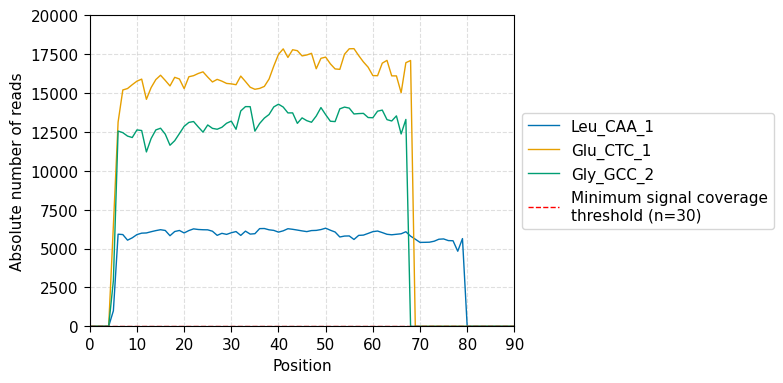

In [16]:
f5c_IVT_coverage_df = f5c_coverage_df(
    f5c_output_IVT_Leu, f5c_output_IVT_Glu, f5c_output_IVT_Gly, 
    positions_range=[0, 100])
plot_coverage_lines(f5c_IVT_coverage_df, 
                            sample_labels= ['Leu_CAA_1', 'Glu_CTC_1', 'Gly_GCC_2']
                            , title=None, yticks=(0, 20001, 2500))

### Comparison between Remora and f5c

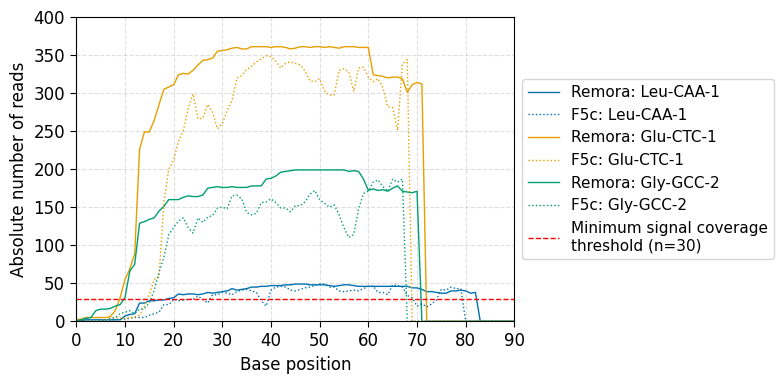

In [17]:
plot_coverage_lines_Remora_vs_f5c(
    coverage_df_Remora = remora_bio_coverage_df, 
    coverage_df_f5c = f5c_bio_coverage_df, 
    sample_labels= ['Remora: Leu-CAA-1', 'Remora: Glu-CTC-1', 'Remora: Gly-GCC-2', 'F5c: Leu-CAA-1', 'F5c: Glu-CTC-1', 'F5c: Gly-GCC-2'],
    ylim = (0,400),  plot_legend= 'yes') 

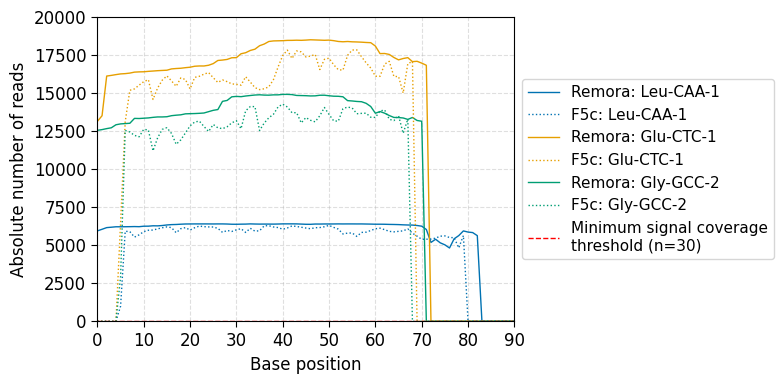

In [18]:
plot_coverage_lines_Remora_vs_f5c(
    coverage_df_Remora = remora_IVT_coverage_df, 
    coverage_df_f5c = f5c_IVT_coverage_df, 
    sample_labels= ['Remora: Leu-CAA-1', 'Remora: Glu-CTC-1', 'Remora: Gly-GCC-2', 'F5c: Leu-CAA-1', 'F5c: Glu-CTC-1', 'F5c: Gly-GCC-2'],
    ylim = (0,20000),  plot_legend= 'yes') 

## 5. Dwell analysis
The dwell is defined as the number of signals assigned to a base position. This is dependent on the translocation speed through the pore and the sampling rate (using RNA004-kit: translocation speed of 130 bp/sec and sampling rate of 4 kHz gives expected dwell of around 30), but is also depending on the signal alignment. The median dwell is the median of dwells among the reads per reference base position.
Below is shown how to infer the dwells per position generated by Remora's and f5c's signal alignment for both biological and IVT sample for three tRNAs.

### For Remora
Extract the dwells from the samples_metrics dataframes and calculate the median dwell per reference base position.

#### Biological sample

In [19]:
# Leu
dwell_bio_Leu = pd.DataFrame(samples_metrics_bio_Leu[0]['dwell'])
# Glu
dwell_bio_Glu = pd.DataFrame(samples_metrics_bio_Glu[0]['dwell'])
# Gly
dwell_bio_Gly = pd.DataFrame(samples_metrics_bio_Gly[0]['dwell'])

--- Dwell Stats for Leu-CAA-1 ---
Minimum: 0.00
Maximum: 2780.00
Median:  16.00
Mean:    62.65
Std:    182.21

--- Dwell Stats for Glu-CTC-1 ---
Minimum: 0.00
Maximum: 2860.00
Median:  16.00
Mean:    65.52
Std:    195.80

--- Dwell Stats for Gly-GCC-2 ---
Minimum: 0.00
Maximum: 2928.00
Median:  16.00
Mean:    66.55
Std:    207.34



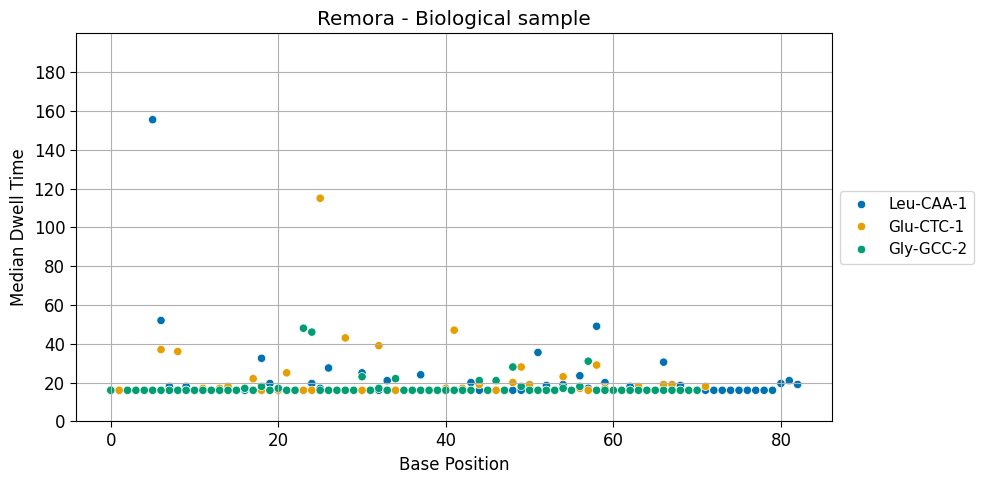

In [20]:
plot_median_dwell_and_stats_remora(
    {
        "Leu-CAA-1": dwell_bio_Leu,
        "Glu-CTC-1": dwell_bio_Glu,
        "Gly-GCC-2": dwell_bio_Gly
    },
    title = 'Remora - Biological sample', legend = 'yes'
)

#### IVT sample

In [21]:
# Leu
dwell_IVT_Leu = pd.DataFrame(samples_metrics_IVT_Leu[0]['dwell'])
# Glu
dwell_IVT_Glu = pd.DataFrame(samples_metrics_IVT_Glu[0]['dwell'])
# Gly
dwell_IVT_Gly = pd.DataFrame(samples_metrics_IVT_Gly[0]['dwell'])

--- Dwell Stats for Leu-CAA-1 ---
Minimum: 0.00
Maximum: 2907.00
Median:  16.00
Mean:    42.57
Std:    97.81

--- Dwell Stats for Glu-CTC-1 ---
Minimum: 0.00
Maximum: 3207.00
Median:  16.00
Mean:    45.66
Std:    111.79

--- Dwell Stats for Gly-GCC-2 ---
Minimum: 0.00
Maximum: 3402.00
Median:  16.00
Mean:    46.53
Std:    116.01



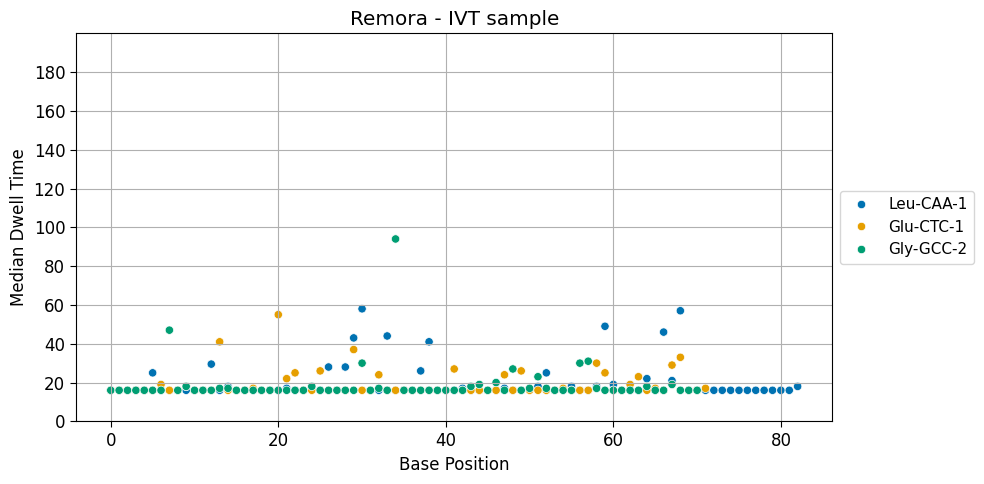

In [22]:
plot_median_dwell_and_stats_remora(
    {
        "Leu-CAA-1": dwell_IVT_Leu,
        "Glu-CTC-1": dwell_IVT_Glu,
        "Gly-GCC-2": dwell_IVT_Gly
    },
    title = 'Remora - IVT sample', legend = 'yes'
)

#### Biological vs. IVT sample in violin plots
Below all the positions are taking together and the distribution of median dwells is visualised in violin plots:

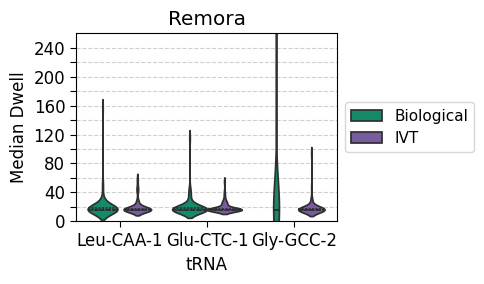

In [23]:
median_leu_bio = dwell_bio_Leu.median()
median_glu_bio = dwell_bio_Glu.median()
median_gly_bio = dwell_bio_Gly.median()

# Combine into one DataFrame
df_median_bio = pd.DataFrame({
    "position": median_leu_bio.index,
    "Leu-CAA-1": median_leu_bio.values,
    "Glu-CTC-1": median_glu_bio.values,
    "Gly-GCC-2": median_gly_bio.values
})
# Melt the wide df_median into long format
df_long_bio = pd.melt(df_median_bio, id_vars=["position"], 
                  var_name="tRNA", value_name="dwell")
df_long_bio['sample']= 'Biological'


dwell_IVT_Leu = pd.DataFrame(samples_metrics_IVT_Leu[0]['dwell'])
dwell_IVT_Glu = pd.DataFrame(samples_metrics_IVT_Glu[0]['dwell'])
dwell_IVT_Gly = pd.DataFrame(samples_metrics_IVT_Gly[0]['dwell'])

# Compute median per position (i.e., column-wise)
median_leu_IVT = dwell_IVT_Leu.median()
median_glu_IVT = dwell_IVT_Glu.median()
median_gly_IVT = dwell_IVT_Gly.median()


# Combine into one DataFrame
df_median_IVT = pd.DataFrame({
    "position": median_leu_IVT.index,
    "Leu-CAA-1": median_leu_IVT.values,
    "Glu-CTC-1": median_glu_IVT.values,
    "Gly-GCC-2": median_gly_IVT.values
})
# Melt the wide df_median into long format
df_long_IVT = pd.melt(df_median_IVT, id_vars=["position"], 
                  var_name="tRNA", value_name="dwell")
df_long_IVT['sample']= 'IVT'



median_combined_all = pd.concat([df_long_bio, df_long_IVT
], ignore_index=True)

plt.figure(figsize=(5, 3))
plt.grid(True, axis='y', linestyle='--', alpha=0.6, zorder = 0)
sns.violinplot(
    data=median_combined_all,
    x="tRNA",
    y="dwell",
    hue="sample",
    palette={"Biological": "#009E73", "IVT": "#7851A9" },
    dodge=True,  # side-by-side in the same violin
    inner="quartile", zorder =2
)

plt.title("Remora")
plt.xlabel("tRNA")
plt.ylabel("Median Dwell")
plt.ylim(0, 260)
# Set yticks every 20, but only label every 40
ytick_vals = np.arange(0, 260, 20)
ytick_labels = [str(val) if val % 40 == 0 else "" for val in ytick_vals]
plt.yticks(ytick_vals, ytick_labels)

plt.legend(
    title="Sample",
    loc="upper left",
    bbox_to_anchor=(1.02, 1),  # x = 1.02 puts it just outside the figure
    borderaxespad=0
)
plt.legend(loc='center left',  bbox_to_anchor=(1.0, 0.5), fontsize=11)
plt.tight_layout()
plt.show()

Below the tRNAs are combined:

       sample  median        std
0  Biological    16.0  51.817909
1         IVT    16.0   8.911820


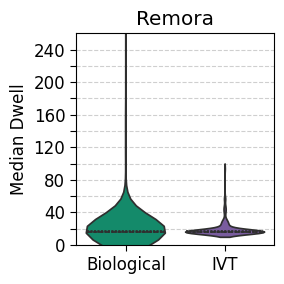

In [24]:
# Combine both Control and IVT into a single DataFrame
median_combined_all = pd.concat([df_long_bio, df_long_IVT], ignore_index=True)

# Drop the tRNA column, since we now want one distribution per sample group
pooled_dwell = median_combined_all[["dwell", "sample"]].copy()

# Combine Control and IVT into one DataFrame without tRNA distinction
pooled_dwell = median_combined_all[["dwell", "sample"]].copy()

# Print median and standard deviation per sample group
summary_stats = pooled_dwell.groupby("sample")["dwell"].agg(["median", "std"]).reset_index()
print(summary_stats)


plt.figure(figsize=(3, 3))
plt.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=0)

# Create violinplot of dwell distributions pooled across all tRNAs
sns.violinplot(
    data=pooled_dwell,
    x="sample",
    y="dwell",
    palette={"Biological": "#009E73", "IVT": "#7851A9"},
    inner="quartile",
    zorder=2
)

plt.title("Remora")
plt.ylabel("Median Dwell")
plt.xlabel("")
plt.ylim(0, 260)

# Custom yticks: every 20, label every 40
ytick_vals = np.arange(0, 260, 20)
ytick_labels = [str(val) if val % 40 == 0 else "" for val in ytick_vals]
plt.yticks(ytick_vals, ytick_labels)

plt.tight_layout()
plt.show()


### For F5c

Compute the dwells based on the signal indices

#### Biological sample

In [25]:
# Leu
f5c_output_bio_Leu['dwell'] = f5c_output_bio_Leu['end_idx'] -f5c_output_bio_Leu['start_idx']
median_leu_bio = f5c_output_bio_Leu.groupby("base_position")["dwell"].median().reset_index()
median_leu_bio["tRNA"] = "Leu-CAA-1"

# Glu
f5c_output_bio_Glu['dwell'] = f5c_output_bio_Glu['end_idx'] -f5c_output_bio_Glu['start_idx']
median_glu_bio = f5c_output_bio_Glu.groupby("base_position")["dwell"].median().reset_index()
median_glu_bio["tRNA"] = "Glu-CTC-1"

# Gly
f5c_output_bio_Gly['dwell'] = f5c_output_bio_Gly['end_idx'] -f5c_output_bio_Gly['start_idx']
median_gly_bio = f5c_output_bio_Gly.groupby("base_position")["dwell"].median().reset_index()
median_gly_bio["tRNA"] = "Gly-GCC-2"

--- Median Dwell Stats for Leu-CAA-1 ---
Minimum: 17.00
Maximum: 170.00
Median:  31.00
Mean:    39.55
Std:     24.43

--- Median Dwell Stats for Glu-CTC-1 ---
Minimum: 10.00
Maximum: 225.00
Median:  29.00
Mean:    33.79
Std:     27.51

--- Median Dwell Stats for Gly-GCC-2 ---
Minimum: 15.00
Maximum: 216.00
Median:  33.00
Mean:    42.43
Std:     36.82



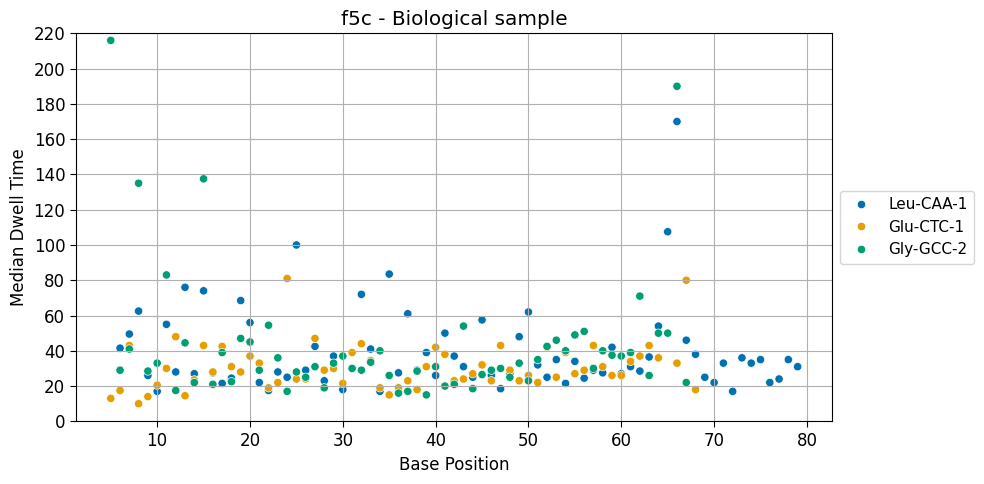

In [26]:
plot_median_dwell_and_stats_f5c(
    {
        "Leu-CAA-1": median_leu_bio,
        "Glu-CTC-1": median_glu_bio,
        "Gly-GCC-2": median_gly_bio
    },
    title = 'f5c - Biological sample', legend = 'yes'
)

#### IVT sample

In [27]:
# Leu
f5c_output_IVT_Leu['dwell'] = f5c_output_IVT_Leu['end_idx'] -f5c_output_IVT_Leu['start_idx']
median_leu_ivt = f5c_output_IVT_Leu.groupby("base_position")["dwell"].median().reset_index()
median_leu_ivt["tRNA"] = "Leu-CAA-1"
# Glu
f5c_output_IVT_Glu['dwell'] = f5c_output_IVT_Glu['end_idx'] -f5c_output_IVT_Glu['start_idx']
median_glu_ivt = f5c_output_IVT_Glu.groupby("base_position")["dwell"].median().reset_index()
median_glu_ivt["tRNA"] = "Glu-CTC-1"
# Gly
f5c_output_IVT_Gly['dwell'] = f5c_output_IVT_Gly['end_idx'] -f5c_output_IVT_Gly['start_idx']
median_gly_ivt = f5c_output_IVT_Gly.groupby("base_position")["dwell"].median().reset_index()
median_gly_ivt["tRNA"] = "Gly-GCC-2"

--- Median Dwell Stats for Leu-CAA-1 ---
Minimum: 13.00
Maximum: 163.00
Median:  29.00
Mean:    33.69
Std:     21.46

--- Median Dwell Stats for Glu-CTC-1 ---
Minimum: 13.00
Maximum: 125.00
Median:  27.50
Mean:    31.89
Std:     16.23

--- Median Dwell Stats for Gly-GCC-2 ---
Minimum: 15.00
Maximum: 113.00
Median:  29.00
Mean:    32.78
Std:     15.81



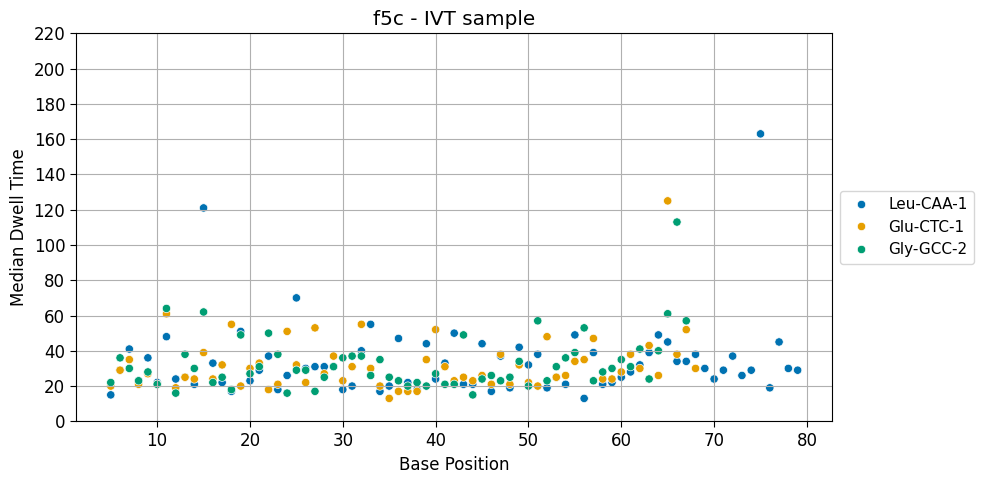

In [28]:
plot_median_dwell_and_stats_f5c(
    {
        "Leu-CAA-1": median_leu_ivt,
        "Glu-CTC-1": median_glu_ivt,
        "Gly-GCC-2": median_gly_ivt
    },
    title= "f5c - IVT sample", legend = 'yes'
)

#### Biological vs. IVT sample in violin plots
Below all the positions are taking together and the distribution of median dwells is visualised in violin plots:

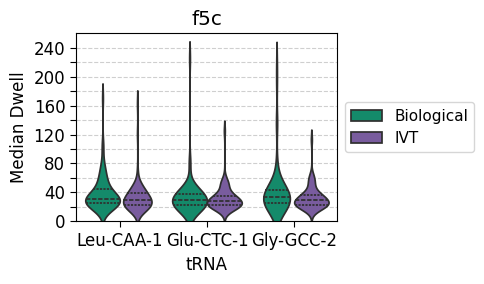

In [29]:
# Rename your control versions
median_leu_bio["sample"] = "Biological"
median_glu_bio["sample"] = "Biological"
median_gly_bio["sample"] = "Biological"

# Add sample labels to IVT versions
median_leu_ivt["sample"] = "IVT"
median_glu_ivt["sample"] = "IVT"
median_gly_ivt["sample"] = "IVT"

median_combined_all = pd.concat([
    median_leu_bio, median_leu_ivt,
    median_glu_bio, median_glu_ivt,
    median_gly_bio, median_gly_ivt
], ignore_index=True)

plt.figure(figsize=(5, 3))
plt.grid(True, axis='y', linestyle='--', alpha=0.6, zorder = 0)
sns.violinplot(
    data=median_combined_all,
    x="tRNA",
    y="dwell",
    hue="sample",
    palette={"Biological": "#009E73", "IVT": "#7851A9" },
    dodge=True,  # side-by-side in the same violin
    inner="quartile", zorder =2
)

plt.title("f5c")
plt.xlabel("tRNA")
plt.ylabel("Median Dwell")
plt.ylim(0, 260)

# Set yticks every 20, but only label every 40
ytick_vals = np.arange(0, 260, 20)
ytick_labels = [str(val) if val % 40 == 0 else "" for val in ytick_vals]
plt.yticks(ytick_vals, ytick_labels)

plt.legend(loc='center left',  bbox_to_anchor=(1.0, 0.5), fontsize=11)

plt.tight_layout()
plt.show()

Below, the tRNAs are combined:

Pooled median dwell stats across all tRNAs (f5c):
       sample  median        std
0  Biological    31.0  22.488510
1         IVT    29.0  18.122387


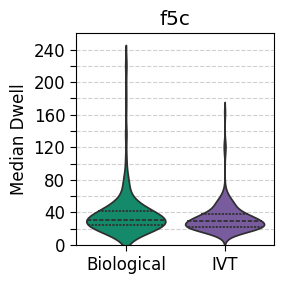

In [30]:
# Combine median dwell values across all tRNAs (pooled across base positions)
pooled_medians_f5c = median_combined_all.groupby(["sample", "base_position"])["dwell"].median().reset_index()

# Compute median of medians and standard deviation per sample
summary_stats_pooled_f5c = pooled_medians_f5c.groupby("sample")["dwell"].agg(["median", "std"]).reset_index()

print("Pooled median dwell stats across all tRNAs (f5c):")
print(summary_stats_pooled_f5c)
# Combine all tRNAs into a single distribution per sample (pooled median dwells)
pooled_violin_f5c = median_combined_all[["base_position", "dwell", "sample"]]

plt.figure(figsize=(3, 3))
plt.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=0)

sns.violinplot(
    data=pooled_violin_f5c,
    x="sample",
    y="dwell",
    hue="sample",
    palette={"Biological": "#009E73", "IVT": "#7851A9"},
    inner="quartile",
    zorder=2
)

# Set plot labels and appearance
plt.title("f5c")
plt.xlabel("")
plt.ylabel("Median Dwell")
plt.ylim(0, 260)

# Set yticks every 20 but label every 40
ytick_vals = np.arange(0, 260, 20)
ytick_labels = [str(val) if val % 40 == 0 else "" for val in ytick_vals]
plt.yticks(ytick_vals, ytick_labels)

plt.tight_layout()
plt.show()